# The Continuous Bag of Words (CBOW) Model

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

In [2]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package gutenberg to /home/kienmn/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/kienmn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kienmn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing the text

In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

In [4]:
def normalize_document(doc):
    # Lowercase and remove special characters/whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # Tokenize document
    tokens = wpt.tokenize(doc)
    # Filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Recreate document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [5]:
from nltk.corpus import gutenberg
from string import punctuation

In [6]:
bible = gutenberg.sents('bible-kjv.txt')
remove_term = punctuation + '0123456789'

In [7]:
bible

[['[', 'The', 'King', 'James', 'Bible', ']'], ['The', 'Old', 'Testament', 'of', 'the', 'King', 'James', 'Bible'], ...]

In [8]:
remove_term

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [9]:
norm_bible = [[word.lower() for word in sent if word not in remove_term] for sent in bible]

In [10]:
norm_bible[:3]

[['the', 'king', 'james', 'bible'],
 ['the', 'old', 'testament', 'of', 'the', 'king', 'james', 'bible'],
 ['the', 'first', 'book', 'of', 'moses', 'called', 'genesis']]

In [11]:
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]

In [12]:
norm_bible[:3]

['the king james bible',
 'the old testament of the king james bible',
 'the first book of moses called genesis']

In [13]:
norm_bible = filter(None, normalize_corpus(norm_bible))

In [14]:
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

In [15]:
norm_bible[:10]

['king james bible',
 'old testament king james bible',
 'first book moses called genesis',
 'beginning god created heaven earth',
 'earth without form void darkness upon face deep',
 'spirit god moved upon face waters',
 'god said let light light',
 'god saw light good god divided light darkness',
 'god called light day darkness called night',
 'evening morning first day']

In [16]:
print('Total lines:', len(bible))
print('Sample line:', bible[10])
print('Processed line:', norm_bible[10])

Total lines: 30103
Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']
Processed line: god said let firmament midst waters let divide waters waters


## Implementing the Continuous Bag of Words (CBOW) Model
### Building the corpus vocabulary

In [17]:
from keras.preprocessing import text, sequence
from keras.utils import np_utils

Using TensorFlow backend.


In [18]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

In [19]:
# Build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v: k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

In [20]:
wids[:3]

[[13, 1154, 5766], [154, 2450, 13, 1154, 5766], [132, 310, 63, 86, 8480]]

In [21]:
vocab_size = len(word2id)
embed_size = 100
window_size = 2

In [22]:
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


### Building a CBOW (context, target) generator

In [23]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size * 2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word = []
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i]
                                  for i in range(start, end)
                                  if 0 <= i < sentence_length
                                  and i != index])
            label_word.append(word)
            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield(x, y)
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])

        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


### Building the CBOW model architecture

In [24]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

In [25]:
# Building CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [26]:
cbow.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            1242500   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12425)             1254925   
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________


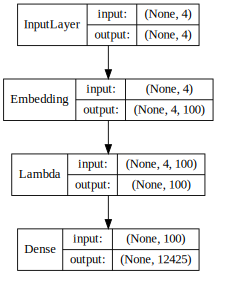

In [27]:
# Visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, rankdir='TB', dpi=65).create(prog='dot', format='svg'))

In [ ]:
# Note: Take quite long time to train

for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)

### Getting word embeddings

In [28]:
weights = cbow.get_weights()[0]
weights = weights[1:]   # Note: weights[0] is for PAD.
weights.shape

(12424, 100)

In [29]:
pd.DataFrame(weights, index=list(id2word.values())[:-1]).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
shall,0.032743,0.004620,0.033932,-0.049682,-0.020793,0.029174,-0.040691,-0.036483,-0.027343,0.025122,...,0.039270,0.013598,0.038559,-0.006084,-0.040633,-0.040619,-0.011261,-0.005539,0.040170,-0.040601
unto,-0.003183,-0.030217,0.024062,-0.033074,0.038236,0.017084,0.022587,-0.032710,-0.020847,-0.012313,...,0.012389,-0.019922,-0.018460,-0.036715,-0.009048,-0.034876,-0.003414,-0.022669,-0.009553,-0.037421
lord,0.046552,0.009463,-0.033299,-0.016541,-0.017908,-0.019655,-0.025923,-0.018011,0.000756,-0.034221,...,0.001636,-0.038869,-0.044725,0.004977,-0.042801,0.020157,-0.034456,-0.011043,0.037131,0.040633
thou,0.025958,0.019875,0.006499,-0.006116,-0.043054,0.027911,0.034857,-0.033050,-0.002873,0.030157,...,0.021045,0.029871,0.024505,0.009087,0.044203,-0.040807,0.001219,0.003751,-0.044954,0.046748
thy,0.017528,0.005626,-0.026871,0.039219,0.036824,0.022392,0.005548,0.044245,-0.013060,0.049354,...,0.003166,-0.021126,0.047324,0.028593,0.008060,0.018543,-0.040648,0.013222,-0.018054,-0.012824


### Finding similar words

In [30]:
from sklearn.metrics.pairwise import euclidean_distances

# Compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

(12424, 12424)


In [31]:
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term] - 1].argsort()[1: 6] + 1]
                for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses', 'famine']}

In [32]:
similar_words

{'god': ['malchielites', 'finished', 'highest', 'treasury', 'spiritually'],
 'jesus': ['meah', 'rolling', 'beareth', 'invited', 'roasted'],
 'noah': ['evi', 'stephen', 'withholdeth', 'jaalah', 'unwittingly'],
 'egypt': ['spin', 'falling', 'uprightness', 'bridle', 'question'],
 'john': ['scythian', 'shetharboznai', 'ripe', 'wonderful', 'marketplace'],
 'gospel': ['emmanuel', 'ought', 'jerah', 'patrimony', 'angels'],
 'moses': ['rebuketh', 'bodies', 'frame', 'zephaniah', 'lock'],
 'famine': ['pointed', 'doorkeeper', 'bethany', 'bushy', 'shunem']}